In [2]:
# Import the necessary python modules
import pandas as pd # v.1.4.3
import numpy as np # v.1.23.0

from scipy import stats # v.1.10.1
import rpy2.rinterface as ri # v.3.5.11
from sklearn import metrics # v.1.2.2
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.proportion import proportion_confint # v.0.13.5
import statsmodels.api as sm
from lifelines import KaplanMeierFitter # v.0.27.7
from lifelines.statistics import logrank_test, multivariate_logrank_test

import matplotlib.pyplot as plt # v.3.7.1
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns # v.0.12.2

from tqdm import tqdm # v.4.65.0

import random # python v.3.9.0
import math

np.random.seed(12345)

In [3]:
# Change the default font of matplotlib to "Arial"
plt.rcParams.update({"font.family":"Arial",})

In [4]:
df_doac = pd.read_csv("data_pneumonia_doac/doac_data_extraction_final.csv", low_memory=False)

# Propensity score matching (PSM)

## Data processing for PSM

In [5]:
# There is 1 categorical variable "apacheadmissiondx" that denotes the specific diagnosis type:
df_doac.apacheadmissiondx.value_counts()

Sepsis, pulmonary                                      5134
Pneumonia, bacterial                                   2035
Pneumonia, other                                        483
Pneumonia, aspiration                                   362
Pneumonia, viral                                         96
Pneumonia, fungal                                         5
Pneumonia, parasitic (i.e., Pneumocystic pneumonia)       3
Name: apacheadmissiondx, dtype: int64

In [6]:
df_doac.groupby("apacheadmissiondx")["doac_binary"].sum()

apacheadmissiondx
Pneumonia, aspiration                                    5
Pneumonia, bacterial                                    56
Pneumonia, fungal                                        0
Pneumonia, other                                        18
Pneumonia, parasitic (i.e., Pneumocystic pneumonia)      0
Pneumonia, viral                                         0
Sepsis, pulmonary                                      128
Name: doac_binary, dtype: int64

The categories (diagnoses) "Pneumonia, viral", "Pneumonia, fungal", "Pneumonia, parasitic (i.e., Pneumocystic pneumonia)" do not contain any patients with DOAC.
Including these categories in our propensity score model would violate the overlap (or common support) assumption, as no patients in these categories received DOAC. 
Therefore, we excluded these categories from our analysis. 

In [7]:
df_doac = df_doac[~df_doac.apacheadmissiondx.str.contains("fungal|parasitic|viral", regex=True, case=False)].copy()

In [8]:
# One-hot-encoding for the categorical column "apacheadmissiondx"
df_doac = df_doac.set_index("patientunitstayid")
df_dummies = pd.get_dummies(df_doac["apacheadmissiondx"], prefix='dx')
df_doac = (pd.concat([df_doac, df_dummies], axis=1)).reset_index()

# Scaling the continuous columns:
lst_continuous_clms = [
    'age',
    'apachescore',
    'BUN_-1440to1440_max',
    'respiration_max_0to1440_u30',
    'systolic_min_0to1440_u30',
    'heartrate_max_0to1440_u30',
    'sao2_min_0to1440_u30',
    'diastolic_min_0to1440_u30',
    'aps_GCS'  
]

df_to_scale = df_doac[['patientunitstayid'] + lst_continuous_clms].copy().set_index("patientunitstayid")
df_to_scale = df_to_scale.rename(columns={clm: f"{clm}_scale" for clm in lst_continuous_clms})

scaler = RobustScaler()
df_to_scale[df_to_scale.columns] = scaler.fit_transform(df_to_scale)

df_to_scale = df_to_scale.reset_index()

df_doac = df_doac.merge(right=df_to_scale, how="left", on="patientunitstayid")

## Matching

In [9]:
# List of the column names of the covariates 
lst_covariates = [
    'gender',
    'pmh_coronary_artery_disease',
    'pmh_CHF_binary',
    'pmh_afib',
    'pmh_obstructive_LD',
    'pmh_home_o2_binary',
    'pmh_diabetes_binary',
    'pmh_prior_renal_insufficiency',
    'pmh_cancer_binary',
    'pmh_HT_binary',
    'pmh_card_valvular_binary',
    'pmh_PE_binary',
    'pmh_venous_thrombosis_binary',
    'pmh_strokes_binary',
    'pmh_mmunosuppression_last_6m_binary',
    'dx_Pneumonia, aspiration',
    'dx_Pneumonia, bacterial',
    'dx_Pneumonia, other',
    'age_scale',
    'apachescore_scale',
    'BUN_-1440to1440_max_scale',
    'respiration_max_0to1440_u30_scale',
    'systolic_min_0to1440_u30_scale',
    'heartrate_max_0to1440_u30_scale',
    'sao2_min_0to1440_u30_scale',
    'diastolic_min_0to1440_u30_scale',
    'aps_GCS_scale'
]

lst_all_clm_matching = lst_covariates + ["patientunitstayid", "doac_binary"]

df_for_matching = df_doac[lst_all_clm_matching].copy()

In [10]:
# calculating and adding the propensity score
X = df_for_matching[lst_covariates]
y = df_for_matching["doac_binary"]

lr = LogisticRegression(penalty=None, class_weight="balanced", max_iter=2000)
lr.fit(X, y)
pred_prob = lr.predict_proba(X)  

df_for_matching['propensity_score'] = pred_prob[:, 1]

# logit of the propensity score
df_for_matching['logit_propensity_score'] = np.log(df_for_matching['propensity_score'] / (1 - df_for_matching['propensity_score'])) 

In [11]:
# Truncate propensity scores at the 0.01 and 0.99 percentiles to eliminate extreme propensity scores
lower, upper = df_for_matching['propensity_score'].quantile([0.01, 0.99])
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

9 patients of the target/treatment group were truncated
153 patients of the control group were truncated


In [12]:
# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

In [13]:
# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2
print(f'The caliper (radius) of 0.2 standard deviation of the logit of the propensity score is: {caliper:.4f}')

The caliper (radius) of 0.2 standard deviation of the logit of the propensity score is: 0.1673


In [14]:
### Adjusting the matching to consider the caliper, to be without replacement, and to identify only partially matched/unmatched patients

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < 3: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= 3:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1

In [15]:
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [16]:
pd.Series(lst_distances_matched).describe()

count    5.940000e+02
mean     1.333634e-03
std      2.209239e-03
min      7.930553e-07
25%      1.767901e-04
50%      5.238868e-04
75%      1.581497e-03
max      1.957814e-02
dtype: float64

In [17]:
lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

## Diagnostics 

### Comparing the array of matching-distances to the caliper

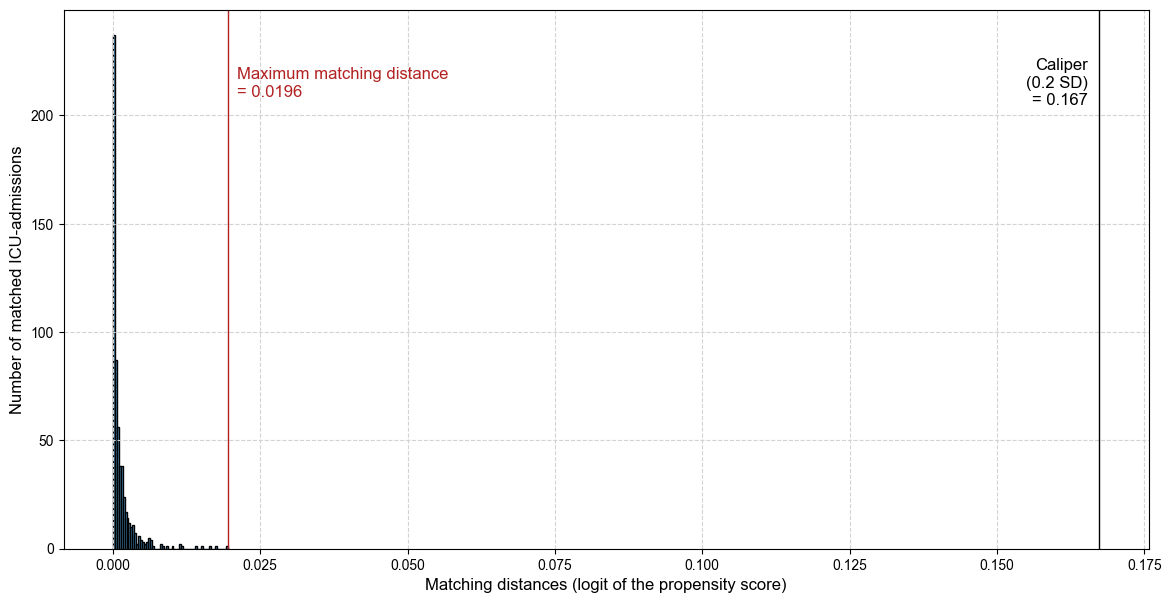

In [18]:
# create an array of the distances of the matches
array_distances = np.array(lst_distances_matched)

# create the figure
fig, ax_hist_dist = plt.subplots(1, 1, figsize=(14,7))

# plot the histogram as well as the lines/text
sns.histplot(x=lst_distances_matched, ax=ax_hist_dist)
ax_hist_dist.axvline(x=caliper, color='black', linestyle='-', lw=1)
ax_hist_dist.text(x=(caliper-0.002), y=215, s='Caliper\n(0.2 SD)\n= {}'.format(round(caliper, 3)), color='black', fontsize=12, horizontalalignment='right', verticalalignment='center')
ax_hist_dist.axvline(x=array_distances.max(), color='firebrick', linestyle='-', lw=1)
ax_hist_dist.text(x=0.021, y=215, s='Maximum matching distance\n= {}'.format(round(array_distances.max(), 4)), color='firebrick', fontsize=12, horizontalalignment='left', verticalalignment='center')

# labels
ax_hist_dist.set_ylabel("Number of matched ICU-admissions", fontsize=12)
ax_hist_dist.set_xlabel("Matching distances (logit of the propensity score)", fontsize=12)
ax_hist_dist.grid(color='lightgray', linestyle='dashed')

plt.show()
plt.clf()

### Distribution of the propensity scores

<Figure size 640x480 with 0 Axes>

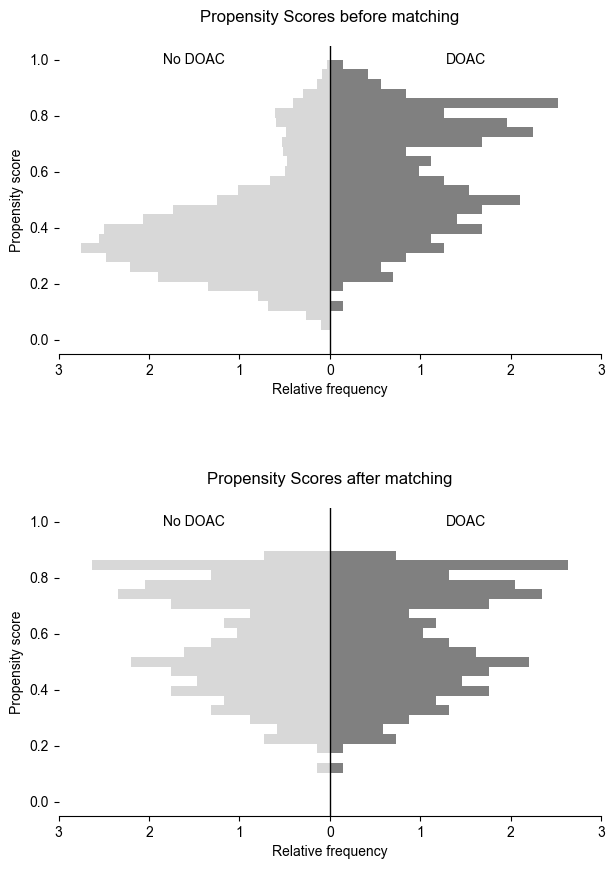

In [19]:
# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(7, 10))

# Create copies of dataframes and map 'doac_binary' to 'doac' (Yes, No)
df_prematch = df_for_matching.copy().rename(columns={"doac_binary": "DOAC"}).replace({"DOAC": {1: "Yes", 0: "No"}})
df_postmatch = df_final_cohort_matched.copy().rename(columns={"doac_binary": "DOAC"}).replace({"DOAC": {1: "Yes", 0: "No"}})

# Filter dataframes for 'No' and 'Yes' doac
df_prematch_no = df_prematch[df_prematch.DOAC == "No"]
df_prematch_yes = df_prematch[df_prematch.DOAC == "Yes"]
df_postmatch_no = df_postmatch[df_postmatch.DOAC == "No"]
df_postmatch_yes = df_postmatch[df_postmatch.DOAC == "Yes"]

# Define bins for histogram
bins = np.linspace(0, 1, 30)

# Plot the histograms and correspronding labels
for ax, df_no, df_yes, title in [(axs[0], df_prematch_no, df_prematch_yes, 'Propensity Scores before matching'),
                                  (axs[1], df_postmatch_no, df_postmatch_yes, 'Propensity Scores after matching')]:
    
    hist_no, bins_no = np.histogram(df_no['propensity_score'], bins=bins, density=True)
    hist_yes, bins_yes = np.histogram(df_yes['propensity_score'], bins=bins, density=True)
    
    ax.barh(bins_no[:-1], -hist_no, height=np.diff(bins_no), align='edge', alpha=0.5, color='.7')
    ax.barh(bins_yes[:-1], hist_yes, height=np.diff(bins_yes), align='edge', alpha=0.5, color='.01') ##010101
    
    ax.set(xlim=(-3, 3))
    
    ax.text(1.5, 1, 'DOAC', va='center', ha='center')
    ax.text(-1.5, 1, 'No DOAC', va='center', ha='center')
    
    ax.axvline(0, color='black', linestyle='-', lw=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(abs(x))))
    
    ax.set_xlabel("Relative frequency")
    ax.set_ylabel("Propensity score")

    ax.set_title(title, y=1.05)


# Adjust space between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.clf()

### Standardized Mean Difference (SMD)

#### Functions for the SMD

In [20]:
def calculate_smd_continuous(data, clm_name_var, clm_name_diff):
    """
    Calculates the Standardized Mean Difference for a continuous variable. From:
    Austin PC. Balance diagnostics for comparing the distribution of baseline covariates between treatment groups in 
    propensity-score matched samples. Stat Med. 2009 Nov 10;28(25):3083-107. doi: 10.1002/sim.3697

    :param data: Dataframe - Data dataframe
    :param clm_name_var: String - the column name of the variable of interest
    :param clm_name_diff: String - the column name of the column that denotes the 2 groups (e.g. treatment vs control)
    has to be binary 1 and 0
    :return: Float - the SMD
    """
    mean_treatment = data.loc[data[clm_name_diff] == 1, clm_name_var].mean()
    mean_control = data.loc[data[clm_name_diff] == 0, clm_name_var].mean()

    var_treatment = data.loc[data[clm_name_diff] == 1, clm_name_var].var()
    var_control = data.loc[data[clm_name_diff] == 0, clm_name_var].var()

    smd = (mean_treatment - mean_control) / np.sqrt(((var_treatment + var_control / 2)))

    return smd


def calculate_smd_binary(data, clm_name_var, clm_name_diff):
    """
    Calculates the Standardized Mean Difference for a binary variable. From:
    Austin PC. Balance diagnostics for comparing the distribution of baseline covariates between treatment groups in 
    propensity-score matched samples. Stat Med. 2009 Nov 10;28(25):3083-107. doi: 10.1002/sim.3697

    :param data: Dataframe - Data dataframe
    :param clm_name_var: String - the column name of the variable of interest
    :param clm_name_diff: String - the column name of the column that denotes the 2 groups (e.g. treatment vs control)
    has to be binary 1 and 0
    :return: Float - the SMD
    """
    p_treatment = data.loc[data[clm_name_diff] == 1, clm_name_var].mean()
    p_control = data.loc[data[clm_name_diff] == 0, clm_name_var].mean()

    smd = (p_treatment - p_control) / np.sqrt(((p_treatment * (1 - p_treatment) + p_control * (1 - p_control)) / 2))

    return smd

#### Calculation/Visualization

In [21]:
# ovariate lists/dictionaries for the following tables/graphs
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

lst_covar_for_smd = [
    'gender',
    'pmh_coronary_artery_disease',
    'pmh_CHF_binary',
    'pmh_afib',
    'pmh_obstructive_LD',
    'pmh_home_o2_binary',
    'pmh_diabetes_binary',
    'pmh_prior_renal_insufficiency',
    'pmh_cancer_binary',
    'pmh_HT_binary',
    'pmh_card_valvular_binary',
    'pmh_PE_binary',
    'pmh_venous_thrombosis_binary',
    'pmh_strokes_binary',
    'pmh_mmunosuppression_last_6m_binary',
    "dx_Sepsis, pulmonary",
    'dx_Pneumonia, aspiration',
    'dx_Pneumonia, bacterial',
    'dx_Pneumonia, other',
    'age',
    'apachescore',
    'BUN_-1440to1440_max',
    'respiration_max_0to1440_u30',
    'systolic_min_0to1440_u30',
    'heartrate_max_0to1440_u30',
    'sao2_min_0to1440_u30',
    'diastolic_min_0to1440_u30',
    'aps_GCS'
]

lst_covar_for_smd_bin = [
    'gender',
    'pmh_coronary_artery_disease',
    'pmh_CHF_binary',
    'pmh_afib',
    'pmh_obstructive_LD',
    'pmh_home_o2_binary',
    'pmh_diabetes_binary',
    'pmh_prior_renal_insufficiency',
    'pmh_cancer_binary',
    'dx_Sepsis, pulmonary',
    'dx_Pneumonia, aspiration',
    'dx_Pneumonia, bacterial',
    'dx_Pneumonia, other',
    'pmh_HT_binary',
    'pmh_card_valvular_binary',
    'pmh_PE_binary',
    'pmh_venous_thrombosis_binary',
    'pmh_strokes_binary',
    'pmh_mmunosuppression_last_6m_binary',
]

dict_covar_names = {
    'gender': "Sex",
    'pmh_coronary_artery_disease': "Coronary artery disease",
    'pmh_CHF_binary': "Congestive heart failure",
    'pmh_afib': "Atrial fibrillation",
    'pmh_obstructive_LD': "Obstructive lung disease",
    'pmh_home_o2_binary': "Home oxygen use",
    'pmh_diabetes_binary': "Diabetes mellitus",
    'pmh_prior_renal_insufficiency': "Renal insufficiency",
    'pmh_cancer_binary': "Cancer",
    'pmh_HT_binary': "Hypertension",
    'pmh_card_valvular_binary': "Caridac valvular disease",
    'pmh_PE_binary': "Pulmonary embolism",
    'pmh_venous_thrombosis_binary': "Venous thrombosis",
    'pmh_strokes_binary': "Stroke",
    'pmh_mmunosuppression_last_6m_binary': "Immunosuppression <6 months",
    'dx_Sepsis, pulmonary': "Diagnosis: Pulmonary sepsis",
    'dx_Pneumonia, aspiration': "Diagnosis: Aspiration pneumonia",
    'dx_Pneumonia, bacterial': "Diagnosis: Bacterial pneumonia",
    'dx_Pneumonia, other': "Diagnosis: Other pneumonia",
    'age': "Age",
    'apachescore': "APACHE-IV score",
    'BUN_-1440to1440_max': "Blood urea nitrogen",
    'respiration_max_0to1440_u30': "Respiratory rate",
    'systolic_min_0to1440_u30': "Systolic blood pressure",
    'heartrate_max_0to1440_u30': "Heartrate",
    'sao2_min_0to1440_u30': "Pulse oxymetry",
    'diastolic_min_0to1440_u30': "Diastolic blood pressure",
    'aps_GCS': "GCS"
}

In [22]:
lst_rows = []

# iterate over the covariates, calculate the SMD (dependent on whether it is a continuous or binary variable) and add it to a growing dataframe
for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch,3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final.set_index("Covariate")

,SMD before matching,SMD after matching
Covariate,,
Sex,0.072,0.017
Coronary artery disease,0.064,-0.043
Congestive heart failure,0.321,-0.065
Atrial fibrillation,0.699,0.034
Obstructive lung disease,0.141,0.003
Home oxygen use,0.085,0.077
Diabetes mellitus,0.013,-0.015
Renal insufficiency,0.114,-0.048
Cancer,0.127,0.016


C:\Users\Martin Ryll\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1), (0.1, 0.1, 0.1)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


<Figure size 640x480 with 0 Axes>

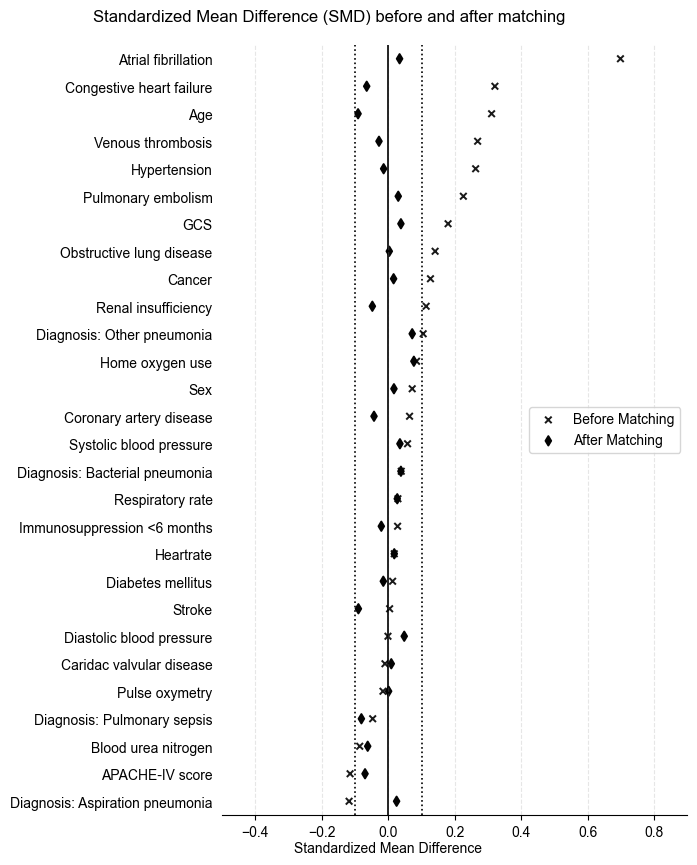

In [23]:
# Sort the values in ascending order (SMD before matching)
df_smd_for_plotting = df_smd_final.sort_values("SMD before matching", ascending=False)

# Initialize the figure
fig, ax_pointplot_smd = plt.subplots(figsize=(6, 10))

# Create the pointplots
sns.pointplot(x='SMD before matching', y='Covariate', data=df_smd_for_plotting, join=False, color='0.1', label='Before Matching', ax=ax_pointplot_smd, markers="x", scale=0.7)
sns.pointplot(x='SMD after matching', y='Covariate', data=df_smd_for_plotting, join=False, color='0.01', label='After Matching', ax=ax_pointplot_smd, markers="d", scale=0.7)

# Add the vertical lines
ax_pointplot_smd.axvline(0, color='black', linestyle='-', lw=1.2)
ax_pointplot_smd.axvline(-0.1, color='black', linestyle='dotted', lw=1.2)
ax_pointplot_smd.axvline(0.1, color='black', linestyle='dotted', lw=1.2)

# layout changes
ax_pointplot_smd.set(xlim=(-0.5, 0.9))
ax_pointplot_smd.xaxis.grid(True, color='.9', linestyle='dashed')
ax_pointplot_smd.spines['top'].set_visible(False)
ax_pointplot_smd.spines['right'].set_visible(False)
ax_pointplot_smd.spines['left'].set_visible(False)
ax_pointplot_smd.yaxis.set_ticks_position('none')

# Locate legend
ax_pointplot_smd.legend(loc="center right")

# Labels
ax_pointplot_smd.set_title('Standardized Mean Difference (SMD) before and after matching', y=1.02,  x=0.23)
ax_pointplot_smd.set_xlabel('')
ax_pointplot_smd.set_ylabel('')
ax_pointplot_smd.text(0, 28.7, 'Standardized Mean Difference', ha='center', va='center')

plt.show()
plt.clf()

# Analysis

In [24]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [25]:
df_doac_matched.doac_binary.value_counts()

0    594
1    198
Name: doac_binary, dtype: int64

## Functions

In [26]:
# A function on how to do a Fisher Exact test via R from python as there is no Fisher Exact test 
# implemented in Python for a contigency table larger than 2x2
def fisher_test_from_contingency_table_rinterface(contingency_table):
    """
    Perform a Fisher Exact test via R on a contigency table and return the p-value. This is mainly
    design for larger contigency tables (> 2x2) as a Fisher Exact test for these is not implemented 
    in Python, yet.
    
    :param contingency_table: Dataframe - contingency table
    
    :return: p-value (float)
    
    """
    # Ensure all index and column labels in the contingency table are strings
    contingency_table.index = contingency_table.index.astype(str)
    contingency_table.columns = contingency_table.columns.astype(str)

    # Activate R bindings
    ri.initr()

    # Convert the contingency table to an R-friendly format
    data_values = ri.FloatSexpVector(contingency_table.values.flatten())
    row_labels = ri.StrSexpVector(contingency_table.index.values)
    col_labels = ri.StrSexpVector(contingency_table.columns.values)
    num_rows = contingency_table.shape[0]
    num_cols = contingency_table.shape[1]

    # Define and evaluate the R script
    # The function switches to p-value approximation if the exact p-value calculation exceeds
    # a workspace of 2e7 (for larger contigency tables e.g. 2x9)
    r_script = f"""
    library(stats)

    matrix_r <- matrix(c({','.join(map(str, data_values))}),
                       nrow = {num_rows}, ncol = {num_cols}, byrow = TRUE)
    colnames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', col_labels))})
    rownames(matrix_r) <- c({','.join(map(lambda x: f'"{x}"', row_labels))})
    contingency_table_r <- as.data.frame(matrix_r)

    tryCatch(
      {{
        result <- fisher.test(contingency_table_r, workspace = 2e7)  # Increase workspace size
        p_value <- result$p.value
        p_value
      }},
      error = function(e){{
        # Catch the workspace error and perform the simulation
        result <- fisher.test(contingency_table_r, simulate.p.value = TRUE)
        p_value <- result$p.value
        p_value
      }}
    )
    """

    # Execute the R script and get the p-value
    p_value = ri.baseenv['eval'](ri.parse(text=r_script))[0]

    # Return the p-value as a float
    return float(p_value)


def agg_binary_count_and_percentage(x):
    """ aggregating function for the binary variables, producing a count and percentage """
    if x.empty:
        return np.nan

    val_cnt = x.dropna().value_counts()

    if 1 not in val_cnt.index:
        return "0 (0%)"

    ones_count = val_cnt.at[1]

    ones_percentage = x.value_counts(normalize=True).at[1] * 100
    ones_percentage = round(ones_percentage, 1)

    return "{} ({}%)".format(ones_count, ones_percentage)


def agg_missing_w_percentage(x):
    """ aggregating function for the missing values, produces a count and a percentage """
    n_missing = x.isna().sum()
    missing_percent = round(((x.isna().sum() / len(x)) * 100), 1)
    return "{} ({}%)".format(n_missing, missing_percent)


def agg_continuous_median_and_iqr(x):
    """ aggregating function for the continuous variables, produces a median and Q25-Q75 """
    if x.empty:
        return np.nan

    quantiles_cont = x.dropna().quantile(q=[0.25, 0.5, 0.75])
    quantiles = [quantiles_cont[0.25], quantiles_cont[0.50], quantiles_cont[0.75]]

    return "{} [{}-{}]".format(round(quantiles[1], 1), round(quantiles[0], 1), round(quantiles[2], 1))
    

def demographics_w_missing_cat_advanced(df_data, diff_clm, lst_binary=None, lst_continuous=None, lst_categories=None, diff_ind=1):
    """
    Creates a formatted overview of how many patients had which feature/variable and then splitting that into 2 groups (typically survivors vs
    non-survivors) and computing a comparison for that. Continuous data are presented as median and IQR while categorical and binary variables as count and percentage. 
    Categorical and binary variables are compared by Chi-Square test or Fisher-Exact test (if any observation is <5). 
    Continuous variables were tested for normal distribution via Shapiro-Wilk test and compared by independent t-test if normally distributed or Mann-Whitney-U test 
    if either group is not normally distributed. For categorical data, a Fisher Exact/Chi-Square test is calculated over all the categories.
    Missing data is shown as percentage.

    :param df_vars: Dataframe - with the data, the different features/variables should be columns
    
    :param lst_binary: List - list of the columns labels with binary Data
        
    :param lst_continuous: List - list of the column names with continuous Data

    :param diff_clm: String - name of the differentiator column (for the comparison)

    :param diff_ind: String/int/float, preset 1 - indicator that markes the one of two groups in the diff_clm currenlty primarily stable/optimized for the int 1

    :return: Dataframe 
    """

    if lst_binary is None:
        lst_binary = []
    if lst_continuous is None:
        lst_continuous = []
    if lst_categories is None:
        lst_categories = []

    if len(lst_binary) > 0:
        lst_binary.append(diff_clm)
    lst_final_dfs = []
    
    # initiate the dataframes for the binary and continuous variables
    df_binary = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"], index=lst_binary)
    df_continuous = pd.DataFrame(
        columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                 "Non_survivors_missing_data", "p-value", "test"],
        index=lst_continuous)

    ## binary variables
    # summarize the binary variables if they are entered
    if len(lst_binary) > 0:
        # summarize the binary variables for the whole cohort
        result_all_binary = df_data[lst_binary].apply(lambda x: agg_binary_count_and_percentage(x))
        df_binary.loc[:, "All patients"] = result_all_binary

        # summarize the binary variables for the 2 groups (survivors vs non-survivors)
        result_split_binary = (df_data[lst_binary].groupby(diff_clm)
                               .agg([agg_binary_count_and_percentage])
                               .droplevel(level=1, axis=1)
                               .transpose()
                               .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_binary.loc[:, ["Survivors", "Non_survivors"]] = result_split_binary

        # calculate and add the p-values for the binary variables (looping over those variables)
        for clm_binary in lst_binary:
            df_contigency = pd.crosstab(df_data[clm_binary], df_data[diff_clm])
            
            # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
            if (df_contigency < 5).any().any() == True:
                fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
                p_value = fisher_pvalue
                test_name = "Fisher Exact"
            else:
                chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
                p_value = chi_pvalue
                test_name = "Chi-Square"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_binary.loc[clm_binary, "p-value"] = p_value
            df_binary.loc[clm_binary, "test"] = test_name

        df_binary.loc[df_binary.Survivors.isna() | df_binary.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for binary variables (whole cohort, survivors, non-survivors)
        all_binary_missing = df_data[lst_binary].apply(lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "All_pat_missing_data"] = all_binary_missing

        diff_binary_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Non_survivors_missing_data"] = diff_binary_missing

        anti_diff_binary_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_binary].apply(
            lambda x: agg_missing_w_percentage(x))
        df_binary.loc[:, "Survivors_missing_data"] = anti_diff_binary_missing

        lst_final_dfs.append(df_binary)
        
        lst_binary.remove(diff_clm)

    ## continuous variables
    # summarize the continuous variables if they are entered
    if len(lst_continuous) > 0:
        # summarize the continuous variables for the whole cohort
        result_all_continuous = df_data[lst_continuous].apply(lambda x: agg_continuous_median_and_iqr(x))
        df_continuous.loc[:, "All patients"] = result_all_continuous

        # summarize the continuous variables for the 2 groups (survivors vs non-survivors)
        lst_continuous_w_diff = lst_continuous + [diff_clm]

        result_split_continuous = (df_data[lst_continuous_w_diff].groupby(diff_clm)
                                   .agg([agg_continuous_median_and_iqr])
                                   .droplevel(level=1, axis=1)
                                   .transpose()
                                   .rename(columns={0: "Survivors", 1: "Non_survivors"}))
        df_continuous.loc[:, ["Survivors", "Non_survivors"]] = result_split_continuous

        # split the data into 2 dataframes for the 2 groups
        df_diff_clm = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].copy()
        df_anti_diff_clm = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].copy()

        # calculate and add the p-values for the continuous variables        
        for clm_cont in lst_continuous:
            df_diff_clm_var = df_diff_clm[clm_cont].dropna()
            df_anti_diff_var = df_anti_diff_clm[clm_cont].dropna()
            statistic_shap_0, p_shap_0 = stats.shapiro(df_anti_diff_var)
            statistic_shap_1, p_shap_1 = stats.shapiro(df_diff_clm_var)
            
            # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test 
            if p_shap_0 < 0.05 or p_shap_1 < 0.05:
                df_diff_clm_var_float = df_diff_clm_var.astype(float) 
                df_anti_diff_var_float = df_anti_diff_var.astype(float)

                statistic_mann, p_value_mann = stats.mannwhitneyu(df_anti_diff_var_float, df_diff_clm_var_float)
                p_value = p_value_mann
                test_name = "Mann-Whitney-U"

            else:
                statistic_t, p_value_t = stats.ttest_ind(df_anti_diff_var, df_diff_clm_var, equal_var=False)
                p_value = p_value_t
                test_name = "Independent t-test"

            if p_value < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_value, 3)

            df_continuous.loc[clm_cont, "p-value"] = p_value
            df_continuous.loc[clm_cont, "test"] = test_name

        df_continuous.loc[df_continuous.Survivors.isna() | df_continuous.Non_survivors.isna(), ["p-value", "test"]] = np.nan

        # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
        all_continuous_missing = df_data[lst_continuous].apply(lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "All_pat_missing_data"] = all_continuous_missing

        diff_continuous_missing = df_data.loc[df_data[diff_clm] == diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Non_survivors_missing_data"] = diff_continuous_missing

        anti_diff_continuous_missing = df_data.loc[df_data[diff_clm] != diff_ind, lst_continuous].apply(
            lambda x: agg_missing_w_percentage(x))
        df_continuous.loc[:, "Survivors_missing_data"] = anti_diff_continuous_missing

        lst_final_dfs.append(df_continuous)

    ## categorical variables
    if len(lst_categories) > 0:
        lst_cat_results_dfs = []
        df_data[lst_categories] = df_data[lst_categories].astype('object')
        
        # iterate over each category, transform them into binary variables per category and calculate the summaries/statistics
        for clm_cat in lst_categories:
            # prepare one category via one-hot-encoding
            df_one_cat = pd.get_dummies(df_data[clm_cat], clm_cat, dummy_na=True)
            df_one_cat[diff_clm] = df_data[diff_clm]
            # get rid of any NaN values
            df_one_cat = df_one_cat[df_one_cat[f"{clm_cat}_nan"] != 1].drop(columns=[f"{clm_cat}_nan"]).copy()
            
            # prepare the dataframe
            df_category_temp = pd.DataFrame(
                columns=["All patients", "All_pat_missing_data", "Survivors", "Survivors_missing_data", "Non_survivors",
                         "Non_survivors_missing_data", "p-value", "test"],
                index=df_one_cat.columns)

            # summarize the categorical variable for the whole cohort
            result_all_cat_binary = df_one_cat.apply(lambda x: agg_binary_count_and_percentage(x))
            df_category_temp.loc[:, "All patients"] = result_all_cat_binary
            
            # summarize the continuous variables for the 2 groups and add them to the dataframe
            result_split_cat_binary = (df_one_cat.groupby(diff_clm)
                                       .agg([agg_binary_count_and_percentage])
                                       .droplevel(level=1, axis=1)
                                       .transpose()
                                       .rename(columns={0: "Survivors", 1: "Non_survivors"}))
            df_category_temp.loc[:, ["Survivors", "Non_survivors"]] = result_split_cat_binary
            
            # Calculate and add the p-values (computed over the whole category)
            contingency_table = pd.crosstab(df_data[clm_cat], df_data[diff_clm])
            chi2, p_val_cat, dof_cat, expected = stats.chi2_contingency(contingency_table)
            test_name = "Chi-Square"
            
            min_expected_frequency = np.min(expected)

            if min_expected_frequency < 5:
                # Perform Fisher's exact test if the minimum expected frequency is less than 5
                p_val_cat = fisher_test_from_contingency_table_rinterface(contingency_table)
                test_name = "Fisher Exact"

            if p_val_cat < 0.001:
                p_value = "< 0.001"
            else:
                p_value = round(p_val_cat, 3)
            
            lst_subcat = [i for i in df_one_cat.columns]
            if 'hospitaldischargestatus' in lst_subcat:
                lst_subcat.remove('hospitaldischargestatus')
            random_subcat_clm = random.choice(lst_subcat) # add the p-value under one random category
 
            df_category_temp.loc[random_subcat_clm, "p-value"] = p_value
            df_category_temp.loc[random_subcat_clm, "test"] = test_name

            # add the count of missing data for continuous variables (whole cohort, survivors, non-survivors)
            one_cat_all_missing_total = df_data[clm_cat].isna().sum()
            one_cat_all_missing_percentage = round(((df_data[clm_cat].isna().sum() / len(df_data[clm_cat])) * 100), 1)
            df_category_temp.loc[:, "All_pat_missing_data"] = "{} ({}%)".format(one_cat_all_missing_total,
                                                                           one_cat_all_missing_percentage)

            one_cat_diff_missing_total = df_data.loc[df_data[diff_clm] == diff_ind, clm_cat].isna().sum()
            one_cat_diff_missing_percentage = round(((df_data.loc[
                                                          df_data[diff_clm] == diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] == diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Non_survivors_missing_data"] = "{} ({}%)".format(one_cat_diff_missing_total,
                                                                                one_cat_diff_missing_percentage)

            one_cat_anti_diff_missing_total = df_data.loc[df_data[diff_clm] != diff_ind, clm_cat].isna().sum()
            one_cat_anti_diff_missing_percentage = round(((df_data.loc[df_data[
                                                                           diff_clm] != diff_ind, clm_cat].isna().sum() / len(
                df_data.loc[df_data[diff_clm] != diff_ind, clm_cat])) * 100), 1)
            df_category_temp.loc[:, "Survivors_missing_data"] = "{} ({}%)".format(one_cat_anti_diff_missing_total,
                                                                                one_cat_anti_diff_missing_percentage)

            df_category_temp.loc[
                df_category_temp.Survivors.isna() | df_category_temp.Non_survivors.isna(), ["p-value", "test"]] = np.nan
            df_category_temp = df_category_temp.drop(diff_clm)
            lst_cat_results_dfs.append(df_category_temp)

        df_categories_final = pd.concat(lst_cat_results_dfs)
        lst_final_dfs.append(df_categories_final)
    
    #  add the binary, continuous and categorical variables together
    df_final = pd.concat(lst_final_dfs)

    return df_final

## Demographics and clinical characteristics before and after matching

In [27]:
# lists and dictionaries
dict_covar_names_for_table = {
    'gender': "Sex",
    'pmh_coronary_artery_disease': "Coronary artery disease",
    'pmh_CHF_binary': "Congestive heart failure",
    'pmh_afib': "Atrial fibrillation",
    'pmh_obstructive_LD': "Obstructive lung disease",
    'pmh_home_o2_binary': "Home oxygen use",
    'pmh_diabetes_binary': "Diabetes mellitus",
    'pmh_prior_renal_insufficiency': "Renal insufficiency",
    'pmh_cancer_binary': "Cancer",
    'pmh_HT_binary': "Hypertension",
    'pmh_card_valvular_binary': "Caridac valvular disease",
    'pmh_PE_binary': "Pulmonary embolism",
    'pmh_venous_thrombosis_binary': "Venous thrombosis",
    'pmh_strokes_binary': "Stroke",
    'pmh_mmunosuppression_last_6m_binary': "Immunosuppression <6 months",
    "apacheadmissiondx": "Primary admission diagnosis",
    'age': "Age",
    'apachescore': "APACHE-IV score",
    'BUN_-1440to1440_max': "Blood urea nitrogen",
    'respiration_max_0to1440_u30': "Respiratory rate",
    'systolic_min_0to1440_u30': "Systolic blood pressure",
    'heartrate_max_0to1440_u30': "Heartrate",
    'sao2_min_0to1440_u30': "Pulse oxymetry",
    'diastolic_min_0to1440_u30': "Diastolic blood pressure",
    'aps_GCS': "GCS"
}

lst_covar_bin_for_table = [
    'Sex',
    'Coronary artery disease',
    'Congestive heart failure',
    'Atrial fibrillation',
    'Obstructive lung disease',
    'Home oxygen use',
    'Diabetes mellitus',
    'Renal insufficiency',
    'Cancer',
    'Hypertension',
    'Caridac valvular disease',
    'Pulmonary embolism',
    'Venous thrombosis',
    'Stroke',
    'Immunosuppression <6 months',
]

lst_covar_cont_for_table = [
    'Age',
    'APACHE-IV score',
    'Blood urea nitrogen',
    'Respiratory rate',
    'Systolic blood pressure',
    'Heartrate',
    'Pulse oxymetry',
    'Diastolic blood pressure',
    'GCS'
]

lst_covar_cat_for_table = ["Primary admission diagnosis"]

In [28]:
df_prematch_for_table = df_doac.copy().rename(columns=dict_covar_names_for_table)
df_prematch_for_table["DOAC therapy"] = df_prematch_for_table.doac_binary

df_table_prematch = demographics_w_missing_cat_advanced(df_data=df_prematch_for_table, 
                                                        diff_clm="doac_binary", 
                                                        lst_binary=lst_covar_bin_for_table, 
                                                        lst_continuous=lst_covar_cont_for_table, 
                                                        lst_categories=lst_covar_cat_for_table,
                                                        diff_ind=1)

df_table_prematch = df_table_prematch.rename(columns={"All patients":"All Patients", 
                                                      "All_pat_missing_data": "All Patients missing data", 
                                                      "Survivors": "No DOAC",
                                                      "Survivors_missing_data": "No DOAC missing data",
                                                      "Non_survivors": "With DOAC",
                                                      "Non_survivors_missing_data": "With DOAC missing data"
                                                     })

df_table_prematch

C:\Users\Martin Ryll\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,All Patients,All Patients missing data,No DOAC,No DOAC missing data,With DOAC,With DOAC missing data,p-value,test
Sex,4288 (53.5%),0 (0.0%),4170 (53.4%),0 (0.0%),118 (57.0%),0 (0.0%),0.341,Chi-Square
Coronary artery disease,1284 (16.0%),0 (0.0%),1246 (16.0%),0 (0.0%),38 (18.4%),0 (0.0%),0.405,Chi-Square
Congestive heart failure,1549 (19.3%),0 (0.0%),1481 (19.0%),0 (0.0%),68 (32.9%),0 (0.0%),< 0.001,Chi-Square
Atrial fibrillation,1101 (13.7%),0 (0.0%),1013 (13.0%),0 (0.0%),88 (42.5%),0 (0.0%),< 0.001,Chi-Square
Obstructive lung disease,2795 (34.9%),0 (0.0%),2709 (34.7%),0 (0.0%),86 (41.5%),0 (0.0%),0.049,Chi-Square
Home oxygen use,623 (7.8%),0 (0.0%),602 (7.7%),0 (0.0%),21 (10.1%),0 (0.0%),0.246,Chi-Square
Diabetes mellitus,2239 (27.9%),0 (0.0%),2180 (27.9%),0 (0.0%),59 (28.5%),0 (0.0%),0.917,Chi-Square
Renal insufficiency,867 (10.8%),0 (0.0%),837 (10.7%),0 (0.0%),30 (14.5%),0 (0.0%),0.107,Chi-Square
Cancer,1493 (18.6%),0 (0.0%),1444 (18.5%),0 (0.0%),49 (23.7%),0 (0.0%),0.072,Chi-Square
Hypertension,4105 (51.2%),0 (0.0%),3973 (50.9%),0 (0.0%),132 (63.8%),0 (0.0%),< 0.001,Chi-Square


In [29]:
df_postmatch_for_table = df_doac.loc[df_doac.patientunitstayid.isin(lst_matched_cohort_ids), :].copy().rename(columns=dict_covar_names_for_table)

df_table_postmatch = demographics_w_missing_cat_advanced(df_data=df_postmatch_for_table, 
                                                        diff_clm="doac_binary", 
                                                        lst_binary=lst_covar_bin_for_table, 
                                                        lst_continuous=lst_covar_cont_for_table, 
                                                        lst_categories=lst_covar_cat_for_table,
                                                        diff_ind=1)

df_table_postmatch = df_table_postmatch.rename(columns={"All patients":"All Patients", 
                                                      "All_pat_missing_data": "All Patients missing data", 
                                                      "Survivors": "No DOAC",
                                                      "Survivors_missing_data": "No DOAC missing data",
                                                      "Non_survivors": "With DOAC",
                                                      "Non_survivors_missing_data": "With DOAC missing data"
                                                     })

df_table_postmatch

,All Patients,All Patients missing data,No DOAC,No DOAC missing data,With DOAC,With DOAC missing data,p-value,test
Sex,443 (55.9%),0 (0.0%),331 (55.7%),0 (0.0%),112 (56.6%),0 (0.0%),0.901,Chi-Square
Coronary artery disease,154 (19.4%),0 (0.0%),118 (19.9%),0 (0.0%),36 (18.2%),0 (0.0%),0.678,Chi-Square
Congestive heart failure,258 (32.6%),0 (0.0%),198 (33.3%),0 (0.0%),60 (30.3%),0 (0.0%),0.484,Chi-Square
Atrial fibrillation,310 (39.1%),0 (0.0%),230 (38.7%),0 (0.0%),80 (40.4%),0 (0.0%),0.737,Chi-Square
Obstructive lung disease,327 (41.3%),0 (0.0%),245 (41.2%),0 (0.0%),82 (41.4%),0 (0.0%),1.0,Chi-Square
Home oxygen use,67 (8.5%),0 (0.0%),47 (7.9%),0 (0.0%),20 (10.1%),0 (0.0%),0.417,Chi-Square
Diabetes mellitus,228 (28.8%),0 (0.0%),172 (29.0%),0 (0.0%),56 (28.3%),0 (0.0%),0.928,Chi-Square
Renal insufficiency,118 (14.9%),0 (0.0%),91 (15.3%),0 (0.0%),27 (13.6%),0 (0.0%),0.645,Chi-Square
Cancer,184 (23.2%),0 (0.0%),137 (23.1%),0 (0.0%),47 (23.7%),0 (0.0%),0.923,Chi-Square
Hypertension,496 (62.6%),0 (0.0%),373 (62.8%),0 (0.0%),123 (62.1%),0 (0.0%),0.932,Chi-Square


## Cox Proportional Hazards model

In [30]:
# Adding/processing the outcome variables
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0)) # right censoring

In [31]:
model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

result_cox_after_psm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: PHReg
=================================================================
Model:                 PH Reg                  Sample size:   792
Dependent variable:    time_to_death_for_cox   Num. events:   140
Ties:                  Breslow                                   
-----------------------------------------------------------------
             log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
doac_binary -0.5792    0.2281 0.5604 -2.5391 0.0111 0.3584 0.8763
=================================================================
Confidence intervals are for the hazard ratios
"""

In [32]:
hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.5604
95% Confidence Interval: (0.3584, 0.8763)


In [93]:
# Cohort pre-matching: 
df_prematch_for_cox = df_doac.copy()
df_prematch_for_cox['time_to_death_for_cox'] = df_prematch_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_prematch_for_cox['time_to_death_unitadmit'].max()+1, 0)) # right censoring

model_cox_before_psm = sm.PHReg.from_formula(
    data=df_prematch_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_prematch_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_before_psm = model_cox_before_psm.fit()

hr_doac_binary_cox_before_psm = np.exp(result_cox_before_psm.params[0])

ci_lower_cox_before_psm, ci_upper_cox_before_psm = np.exp(result_cox_before_psm.conf_int()[0])

print(f"Before Matching: Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_before_psm:.4f}")
print(f"Before Matching: 95% Confidence Interval: ({ci_lower_cox_before_psm:.4f}, {ci_upper_cox_before_psm:.4f})")


Before Matching: Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.7957
Before Matching: 95% Confidence Interval: (0.5354, 1.1825)


## Time-to-death/Survival: Kaplan Meier analysis

In [34]:
df_doac_matched.time_to_death_unitadmit.describe()

count    140.000000
mean       5.848481
std        5.545334
min        0.172200
25%        1.554500
50%        4.329497
75%        8.758975
max       32.818700
Name: time_to_death_unitadmit, dtype: float64

In [35]:
# add 34 for all patients that were alive to right-censor all data at that point
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

In [36]:
# creating a formatter that can change axes-labels to percent
def to_percent(value, position):
    return f"{value * 100:.0f}%"

percent_formatter = FuncFormatter(to_percent)

In [37]:
group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

0.010030908248649526


<Figure size 640x480 with 0 Axes>

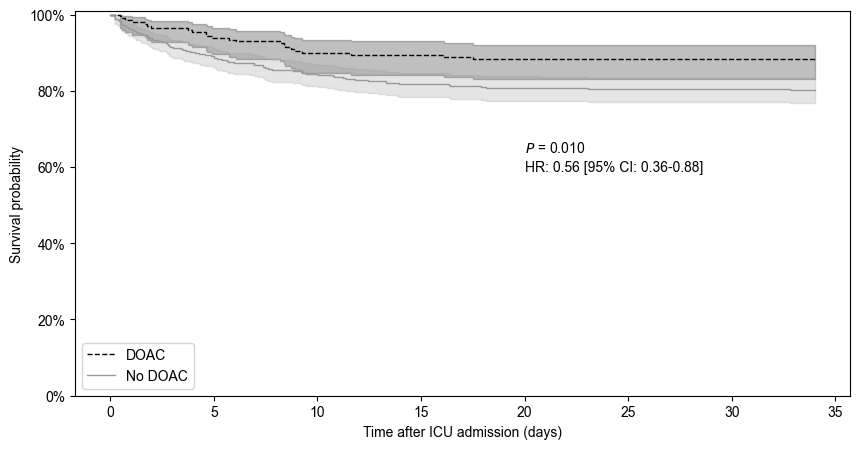

In [38]:
# initiate the Fitter
kmf = KaplanMeierFitter()

# create a figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# fit the model for each group and plot the survival function
kmf.fit(group_doac['time_to_death_for_cox'], event_observed=group_doac['hospitaldischargestatus'], label='DOAC')
kmf.plot(ax=ax1, ci_show=True, loc=slice(0, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0)), linewidth=1.0, color="0.01", linestyle="dashed")

kmf.fit(group_no_doac['time_to_death_for_cox'], event_observed=group_no_doac['hospitaldischargestatus'], label='No DOAC')
kmf.plot(ax=ax1, ci_show=True, loc=slice(0, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0)), linewidth=1.0, color="0.6")

ax1.set_xlabel('Time after ICU admission (days)')
ax1.set_ylabel('Survival probability')
ax1.set(ylim=(0.0,1.01))

# Log-rank test
results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])
print(results_km.p_value)

ax1.text(20, 0.65, f'$P$ = 0.010', ha='left', va='center') # print the p value directly as rounding will shorten it to "0.01" otherwise
ax1.text(20, 0.60, f'HR: {hr_doac_binary_cox_after_psm:.2f} [95% CI: {ci_lower_cox_after_psm:.2f}-{ci_upper_cox_after_psm:.2f}]', ha='left', va='center')

ax1.yaxis.set_major_formatter(percent_formatter)

plt.show()
plt.clf()

## Binary outcomes

In [39]:
# lists and dictionaries 
dict_bin_outcomes = {
    "hospitaldischargestatus": "In-hospital mortality",
    "unitdischargestatus": "In-unit mortality",
    "fresh_intub_on_admission": "Intubation on admission",
    "fist_day_or_admission_aki": "AKI on admission",
    "aki_wo_firstday_or_admission": "AKI during the ICU stay",
    "new_acute_dialysis": "New onset RRT",
    "infusion_vaso_ino": "Need of vasopressor/inotrope infusions on admission",
}

lst_bin_outcome_clms = list(dict_bin_outcomes.keys())
lst_bin_outcome_clms_and_doac = lst_bin_outcome_clms + ["doac_binary"]

In [40]:
def agg_percentage_95ci(x):
    """Function to aggregate a column to output a string in the format "proportion [95% CI]" """
    percent = x.mean()
    conf_int = proportion_confint(x.sum(), len(x), alpha=0.05)
    
    return f"{round(percent*100, 1)}% [{round(conf_int[0]*100, 1)}% - {round(conf_int[1]*100, 1)}%]"


df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,19.7% [16.5% - 22.9%],11.6% [7.2% - 16.1%],0.013,Chi-Square
1,In-unit mortality,13.3% [10.6% - 16.0%],6.1% [2.7% - 9.4%],0.008,Chi-Square
2,Intubation on admission,23.7% [20.3% - 27.2%],23.7% [17.8% - 29.7%],1.000,Chi-Square
3,AKI on admission,15.5% [12.6% - 18.4%],11.1% [6.7% - 15.5%],0.161,Chi-Square
4,AKI during the ICU stay,28.5% [20.5% - 27.3%],29.5% [20.1% - 32.4%],0.859,Chi-Square
5,New onset RRT,2.5% [1.3% - 3.8%],0.0% [0.0% - 0.0%],0.029,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,18.5% [15.4% - 21.6%],15.2% [10.2% - 20.1%],0.333,Chi-Square


## Continuous outcomes

In [41]:
lst_cont_outcomes = ['ICU_free_days', 'unabridgedactualventdays', 'vent_days_alive', 'dialysis_days']

In [42]:
df_doac_matched.groupby("doac_binary")[lst_cont_outcomes].apply(lambda x: x.notna().sum())

,ICU_free_days,unabridgedactualventdays,vent_days_alive,dialysis_days
doac_binary,,,,
0,594,266,192,14
1,198,90,74,0


In [43]:
s, p_shap_dialysis_days = stats.shapiro(df_doac_matched_no_doac.dialysis_days.dropna())
print(f"P-value Shapiro Wilk test for the durations of the dialysis in the group without DOAC: {p_shap_dialysis_days}")

P-value Shapiro Wilk test for the durations of the dialysis in the group without DOAC: 8.245687058661133e-05


In [44]:
df_doac_matched_no_doac.dialysis_days.median()

1.5

In [45]:
df_doac_matched_no_doac.dialysis_days.quantile([0.25, 0.75])

0.25    1.00
0.75    3.75
Name: dialysis_days, dtype: float64

The group receiving the DOAC did not have anyone starting dialysis while on ICU. (=0) At the same time the duration of dialysis in the group without DOAC does not follow a
normal distribution. Thus, a Wilcoxon-Signed-Rank test is used to test whether the vector of dialysis-durations is significantly different from a population mean of 0.

In [46]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 0.0001220703125


In [47]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,27.3 [20.1-28.7],27.8 [24.7-28.8],0.063,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-5.0],3.0 [2.0-4.0],0.851,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.844,Mann-Whitney-U


## Adjusting for multiple tests

### Function

In [48]:
def benjamini_hochberg(df_p_vals, Q=0.1, alpha=0.05):
    """
    Performs the Benjamini-Hochberg procedure to control the false discovery rate for multiple tests.
    
    :param df_p_vals: Dataframe - with 2 columns: 'variables' (Names of the variables/outcomes etc), 
    'pval'(Corresponding p-values as floats)
    
    :param Q: Float, default 0.1 - False Positive Rate
    
    :param alpha: Float, default 0.05 - Significance level of the study
    
    :return: Dataframe - with 5 columns:
        - 'variables': Names of the variables/outcomes
        - 'pval': The p-value
        - 'ranks': The ranks of each p-value
        - '(i/m)*Q': The threshold for significance for each test
        - 'significant': A boolean inidcator whether the p-value is considered significant
    """
    # Sort and rank the p-values
    sorted_pvals = df_p_vals.sort_values(by="pval").reset_index(drop=True)
    sorted_pvals["ranks"] = sorted_pvals.index + 1

    # Calculate (i/m)*Q
    m = len(sorted_pvals)
    sorted_pvals["(i/m)*Q"] = (sorted_pvals["ranks"] / m) * Q
    
    # Identify where p-values are less than or equal to (i/m)*Q and also significant
    sorted_pvals["significant"] = sorted_pvals["pval"] <= sorted_pvals["(i/m)*Q"]
    sorted_pvals["significant"] = sorted_pvals["significant"] & (sorted_pvals["pval"] <= alpha)
    
    return sorted_pvals


### Calculation

In [49]:
# Merge all p-values and their descriptions into 1 dataframe
df_cont_pvals = df_for_cont_outcomes[["Continuous outcomes", "p-value"]].rename(columns={"Continuous outcomes": "variables", "p-value": "pval"})
df_cont_pvals.loc[3] = ["Days on dialysis", p_dialysis_days]

df_bin_pvals = df_bin_outcomes[["Binary outcomes", "p-value"]].rename(columns={"Binary outcomes": "variables", "p-value": "pval"})

df_pvals = pd.concat([df_cont_pvals, df_bin_pvals])

In [50]:
df_p_benj_hoch = benjamini_hochberg(df_p_vals=df_pvals, Q=0.1, alpha=0.05)
df_p_benj_hoch

,variables,pval,ranks,(i/m)*Q,significant
0,Days on dialysis,0.000122,1,0.009091,True
1,In-unit mortality,0.008000,2,0.018182,True
2,In-hospital mortality,0.013000,3,0.027273,True
3,New onset RRT,0.029000,4,0.036364,True
4,ICU-free days,0.063000,5,0.045455,False
5,AKI on admission,0.161000,6,0.054545,False
6,Need of vasopressor/inotrope infusions on admi...,0.333000,7,0.063636,False
7,Ventilation days for the surviving patients,0.844000,8,0.072727,False
8,Ventilation days,0.851000,9,0.081818,False
9,AKI during the ICU stay,0.859000,10,0.090909,False


# Sensitivity analysis with different PSM settings

## 1:3 matching, 2.5th/97.5th percentile truncation

In [51]:
trunc_percentiles = [0.025, 0.975]
n_match = 3

# Truncate propensity scores
lower, upper = df_for_matching['propensity_score'].quantile(trunc_percentiles)
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2

### Adjusting the matching to consider the caliper, to be without replacement and to identify only partially matched/unmatched patients
### (after both considerations are applied)

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < n_match: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= n_match:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1
        
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

18 patients of the target/treatment group were truncated
384 patients of the control group were truncated
Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [52]:
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()
lst_rows = []

for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch, 3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final["Over_0.1"] = df_smd_final["SMD after matching"].map(lambda x: True if abs(x) > 0.1 else False)
print(df_smd_final["Over_0.1"].sum())
df_smd_final.set_index("Covariate")

1


,SMD before matching,SMD after matching,Over_0.1
Covariate,,,
Sex,0.072,0.032,False
Coronary artery disease,0.064,-0.031,False
Congestive heart failure,0.321,-0.076,False
Atrial fibrillation,0.699,0.018,False
Obstructive lung disease,0.141,0.007,False
Home oxygen use,0.085,0.061,False
Diabetes mellitus,0.013,-0.008,False
Renal insufficiency,0.114,-0.046,False
Cancer,0.127,-0.008,False


In [53]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [54]:
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0))
df_for_cox = df_for_cox.rename(columns={
    'dx_Pneumonia, aspiration': 'dx_Pneumonia_aspiration',
    'dx_Pneumonia, bacterial': 'dx_Pneumonia_bacterial',
    'dx_Pneumonia, other': 'dx_Pneumonia_other',
    'BUN_-1440to1440_max_scale': 'BUN_minus1440to1440_max_scale',
    
})

model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.4953
95% Confidence Interval: (0.3080, 0.7966)


In [55]:
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])

print(f"p-value log-rank test = {round(results_km.p_value, 3)}")

p-value log-rank test = 0.003


In [56]:
df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,20.1% [16.8% - 23.4%],10.6% [6.2% - 15.0%],0.004,Chi-Square
1,In-unit mortality,13.6% [10.8% - 16.4%],5.8% [2.5% - 9.2%],0.006,Chi-Square
2,Intubation on admission,23.8% [20.3% - 27.3%],23.8% [17.7% - 29.9%],1.000,Chi-Square
3,AKI on admission,15.2% [12.2% - 18.1%],11.6% [7.1% - 16.2%],0.280,Chi-Square
4,AKI during the ICU stay,28.5% [20.5% - 27.5%],30.5% [20.7% - 33.3%],0.680,Chi-Square
5,New onset RRT,2.5% [1.2% - 3.7%],0.0% [0.0% - 0.0%],0.027,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,18.7% [15.5% - 21.9%],15.3% [10.2% - 20.5%],0.351,Chi-Square


In [57]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 0.000244140625


In [58]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,27.3 [20.0-28.6],27.8 [24.7-28.8],0.037,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-5.0],3.0 [2.0-4.0],0.728,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.902,Mann-Whitney-U


## 1:2 matching, 1st/99th percentile truncation

In [59]:
trunc_percentiles = [0.01, 0.99]
n_match = 2

# Truncate propensity scores
lower, upper = df_for_matching['propensity_score'].quantile(trunc_percentiles)
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2

### Adjusting the matching to consider the caliper, to be without replacement and to identify only partially matched/unmatched patients
### (after both considerations are applied)

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < n_match: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= n_match:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1
        
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

9 patients of the target/treatment group were truncated
153 patients of the control group were truncated
Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [60]:
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()
lst_rows = []

for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch, 3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final["Over_0.1"] = df_smd_final["SMD after matching"].map(lambda x: True if abs(x) > 0.1 else False)
print(df_smd_final["Over_0.1"].sum())
df_smd_final.set_index("Covariate")

1


,SMD before matching,SMD after matching,Over_0.1
Covariate,,,
Sex,0.072,0.020,False
Coronary artery disease,0.064,-0.039,False
Congestive heart failure,0.321,-0.086,False
Atrial fibrillation,0.699,0.015,False
Obstructive lung disease,0.141,0.026,False
Home oxygen use,0.085,0.099,False
Diabetes mellitus,0.013,0.006,False
Renal insufficiency,0.114,-0.022,False
Cancer,0.127,-0.012,False


In [61]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [62]:
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0))
df_for_cox = df_for_cox.rename(columns={
    'dx_Pneumonia, aspiration': 'dx_Pneumonia_aspiration',
    'dx_Pneumonia, bacterial': 'dx_Pneumonia_bacterial',
    'dx_Pneumonia, other': 'dx_Pneumonia_other',
    'BUN_-1440to1440_max_scale': 'BUN_minus1440to1440_max_scale',
    
})

model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.5161
95% Confidence Interval: (0.3254, 0.8186)


In [63]:
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])

print(f"p-value log-rank test = {round(results_km.p_value, 3)}")

p-value log-rank test = 0.004


In [64]:
df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,21.2% [17.2% - 25.2%],11.6% [7.2% - 16.1%],0.006,Chi-Square
1,In-unit mortality,13.9% [10.5% - 17.3%],6.1% [2.7% - 9.4%],0.007,Chi-Square
2,Intubation on admission,24.5% [20.3% - 28.7%],23.7% [17.8% - 29.7%],0.919,Chi-Square
3,AKI on admission,13.9% [10.5% - 17.3%],11.1% [6.7% - 15.5%],0.412,Chi-Square
4,AKI during the ICU stay,28.1% [19.8% - 28.2%],29.5% [20.1% - 32.4%],0.811,Chi-Square
5,New onset RRT,1.8% [0.5% - 3.1%],0.0% [0.0% - 0.0%],0.102,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,18.4% [14.6% - 22.3%],15.2% [10.2% - 20.1%],0.378,Chi-Square


In [65]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 0.03125


In [66]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,27.3 [19.0-28.6],27.8 [24.7-28.8],0.072,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-5.0],3.0 [2.0-4.0],0.682,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.815,Mann-Whitney-U


## 1:2 matching, 2.5th/97.5th percentile truncation

In [67]:
trunc_percentiles = [0.025, 0.975]
n_match = 2

# Truncate propensity scores
lower, upper = df_for_matching['propensity_score'].quantile(trunc_percentiles)
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2

### Adjusting the matching to consider the caliper, to be without replacement and to identify only partially matched/unmatched patients
### (after both considerations are applied)

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < n_match: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= n_match:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1
        
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

18 patients of the target/treatment group were truncated
384 patients of the control group were truncated
Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [68]:
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()
lst_rows = []

for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch, 3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final["Over_0.1"] = df_smd_final["SMD after matching"].map(lambda x: True if abs(x) > 0.1 else False)
print(df_smd_final["Over_0.1"].sum())
df_smd_final.set_index("Covariate")

3


,SMD before matching,SMD after matching,Over_0.1
Covariate,,,
Sex,0.072,0.027,False
Coronary artery disease,0.064,-0.027,False
Congestive heart failure,0.321,-0.097,False
Atrial fibrillation,0.699,0.000,False
Obstructive lung disease,0.141,0.032,False
Home oxygen use,0.085,0.084,False
Diabetes mellitus,0.013,0.018,False
Renal insufficiency,0.114,-0.031,False
Cancer,0.127,-0.037,False


In [69]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [70]:
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0))
df_for_cox = df_for_cox.rename(columns={
    'dx_Pneumonia, aspiration': 'dx_Pneumonia_aspiration',
    'dx_Pneumonia, bacterial': 'dx_Pneumonia_bacterial',
    'dx_Pneumonia, other': 'dx_Pneumonia_other',
    'BUN_-1440to1440_max_scale': 'BUN_minus1440to1440_max_scale',
    
})

model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.4487
95% Confidence Interval: (0.2754, 0.7312)


In [71]:
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])

print(f"p-value log-rank test = {round(results_km.p_value, 3)}")

p-value log-rank test = 0.001


In [72]:
df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,22.0% [17.8% - 26.1%],10.6% [6.2% - 15.0%],0.001,Chi-Square
1,In-unit mortality,14.6% [11.0% - 18.1%],5.8% [2.5% - 9.2%],0.004,Chi-Square
2,Intubation on admission,24.9% [20.5% - 29.2%],23.8% [17.7% - 29.9%],0.863,Chi-Square
3,AKI on admission,13.0% [9.6% - 16.3%],11.6% [7.1% - 16.2%],0.753,Chi-Square
4,AKI during the ICU stay,28.8% [20.5% - 29.2%],30.5% [20.7% - 33.3%],0.773,Chi-Square
5,New onset RRT,1.9% [0.5% - 3.2%],0.0% [0.0% - 0.0%],0.102,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,19.0% [15.1% - 23.0%],15.3% [10.2% - 20.5%],0.332,Chi-Square


In [73]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 0.03125


In [74]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,27.3 [17.6-28.6],27.8 [24.7-28.8],0.034,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-5.0],3.0 [2.0-4.0],0.566,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.925,Mann-Whitney-U


## 1:1 matching, 1st/99th percentile truncation

In [75]:
trunc_percentiles = [0.01, 0.99]
n_match = 1

# Truncate propensity scores
lower, upper = df_for_matching['propensity_score'].quantile(trunc_percentiles)
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2

### Adjusting the matching to consider the caliper, to be without replacement and to identify only partially matched/unmatched patients
### (after both considerations are applied)

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < n_match: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= n_match:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1
        
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

9 patients of the target/treatment group were truncated
153 patients of the control group were truncated
Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [76]:
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()
lst_rows = []

for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch, 3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final["Over_0.1"] = df_smd_final["SMD after matching"].map(lambda x: True if abs(x) > 0.1 else False)
print(df_smd_final["Over_0.1"].sum())
df_smd_final.set_index("Covariate")

6


,SMD before matching,SMD after matching,Over_0.1
Covariate,,,
Sex,0.072,-0.031,False
Coronary artery disease,0.064,-0.051,False
Congestive heart failure,0.321,-0.097,False
Atrial fibrillation,0.699,-0.031,False
Obstructive lung disease,0.141,0.031,False
Home oxygen use,0.085,0.108,True
Diabetes mellitus,0.013,-0.011,False
Renal insufficiency,0.114,-0.029,False
Cancer,0.127,-0.058,False


In [77]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [78]:
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0))
df_for_cox = df_for_cox.rename(columns={
    'dx_Pneumonia, aspiration': 'dx_Pneumonia_aspiration',
    'dx_Pneumonia, bacterial': 'dx_Pneumonia_bacterial',
    'dx_Pneumonia, other': 'dx_Pneumonia_other',
    'BUN_-1440to1440_max_scale': 'BUN_minus1440to1440_max_scale',
    
})

model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.4785
95% Confidence Interval: (0.2895, 0.7908)


In [79]:
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])

print(f"p-value log-rank test = {round(results_km.p_value, 3)}")

p-value log-rank test = 0.003


In [80]:
df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,22.7% [16.9% - 28.6%],11.6% [7.2% - 16.1%],0.005,Chi-Square
1,In-unit mortality,13.6% [8.9% - 18.4%],6.1% [2.7% - 9.4%],0.018,Chi-Square
2,Intubation on admission,24.7% [18.7% - 30.8%],23.7% [17.8% - 29.7%],0.907,Chi-Square
3,AKI on admission,15.2% [10.2% - 20.1%],11.1% [6.7% - 15.5%],0.298,Chi-Square
4,AKI during the ICU stay,27.1% [16.9% - 28.6%],29.5% [20.1% - 32.4%],0.704,Chi-Square
5,New onset RRT,1.0% [0.0% - 2.4%],0.0% [0.0% - 0.0%],0.499,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,18.2% [12.8% - 23.6%],15.2% [10.2% - 20.1%],0.500,Chi-Square


In [81]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 1.0


In [82]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,26.8 [16.4-28.4],27.8 [24.7-28.8],0.013,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-6.0],3.0 [2.0-4.0],0.190,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.459,Mann-Whitney-U


## 1:1 matching, 2.5th/97.5th percentile truncation

In [83]:
trunc_percentiles = [0.025, 0.975]
n_match = 1

# Truncate propensity scores
lower, upper = df_for_matching['propensity_score'].quantile(trunc_percentiles)
df_for_matching_truncated = df_for_matching[(df_for_matching['propensity_score'] > lower) & (df_for_matching['propensity_score'] < upper)].copy()
df_for_matching_truncated = df_for_matching_truncated.reset_index(drop=True)

n_doac_pat_trunc = df_for_matching["doac_binary"].sum() - df_for_matching_truncated["doac_binary"].sum()
n_control_pat_trunc = df_for_matching[df_for_matching["doac_binary"] == 0].shape[0] - df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].shape[0]

print(f"{n_doac_pat_trunc} patients of the target/treatment group were truncated")
print(f"{n_control_pat_trunc} patients of the control group were truncated")

# Separate the data into doac and no-doac (control) groups
doac = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 1].reset_index(drop=True)
control = df_for_matching_truncated[df_for_matching_truncated["doac_binary"] == 0].reset_index(drop=True)

# setup knn with the no-doac group
knn = NearestNeighbors(n_neighbors=15).fit(control[['logit_propensity_score']])

# Find the nearest neighbors (=best matches) for each doac-patients in the control (no-doac) group
distances, indices = knn.kneighbors(doac[['logit_propensity_score']])

# calculate the caliper
caliper = np.std(df_for_matching_truncated['logit_propensity_score']) * 0.2

### Adjusting the matching to consider the caliper, to be without replacement and to identify only partially matched/unmatched patients
### (after both considerations are applied)

# initiate lists and variables
lst_matched = []
lst_distances_matched = []
lst_idx_unmatched = []
lst_idx_partially_matched = []
current_treat_idx = 0
counter_partially_matched = 0
counter_unmatched = 0

# Iterate over the distances/indices for the neigbours of each doac patient
for row1, row2 in zip(indices, distances):
    # Create a list of tuples from the indices/distances of 1 doac patient
    row_tuples = [(row1[i], row2[i]) for i in range(len(row1))]

    # Filter out neighbors where the distance is > caliper
    row_tuples = [t for t in row_tuples if t[1] <= caliper]

    # Filter out neighbors that have already been matched
    row_tuples = [t for t in row_tuples if t[0] not in lst_matched]

    # sort the tuples based on the distance (ascending order)
    row_tuples = sorted(row_tuples, key=lambda x: x[1])
    
    # identify patients that are partially matched/unmatched after deleting duplicate matches and applying the caliper
    if len(row_tuples) < n_match: 
        if len(row_tuples) == 0: # unmatched patients
            counter_unmatched = counter_unmatched + 1
            lst_idx_unmatched.append(current_treat_idx)

        else: # partially matched patients
            counter_partially_matched = counter_partially_matched + 1
            lst_idx_unmatched.append(lst_idx_partially_matched)

    current_treat_idx = current_treat_idx + 1

    # counter for the number of final neighbors
    counter = 0

    # iterate over the neighbours of 1 treatment patient
    for idx, dist in row_tuples:
        # break when the full number of neighbors is found
        if counter >= n_match:
            continue

        lst_matched.append(idx)
        lst_distances_matched.append(dist)

        counter = counter + 1
        
# dataframe and list of all the ids of the matched patients from the controls (no DOAC)
df_matched_controls = control.loc[control.index.isin(lst_matched)].copy()
lst_ids_matched_controls = list(df_matched_controls["patientunitstayid"].unique())

# dataframe and list of all the ids of the matched patients from the DOAC patients
lst_exclude_treat_idx = lst_idx_unmatched + lst_idx_partially_matched
df_matched_doac = doac.loc[~doac.index.isin(lst_exclude_treat_idx)].copy()
lst_ids_matched_doac = list(df_matched_doac["patientunitstayid"].unique())

# joining the final control/treatment ids and dataframes
lst_all_matched_ids = lst_ids_matched_controls + lst_ids_matched_doac
df_final_matched = pd.concat([df_matched_doac, df_matched_controls])

print(f"Unmatched treatment patients: {counter_unmatched}")
print(f"Partially matched treatment patients: {counter_partially_matched}")

lst_matched_cohort_ids = lst_all_matched_ids.copy()
df_final_cohort_matched = df_final_matched.copy()

18 patients of the target/treatment group were truncated
384 patients of the control group were truncated
Unmatched treatment patients: 0
Partially matched treatment patients: 0


In [84]:
df_matched_for_smd = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()
lst_rows = []

for covariate in lst_covar_for_smd:
    if covariate in lst_covar_for_smd_bin:
        smd_prematch = calculate_smd_binary(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_binary(df_matched_for_smd, covariate, "doac_binary")
    else:
        smd_prematch = calculate_smd_continuous(df_doac, covariate, "doac_binary")
        smd_postmatch = calculate_smd_continuous(df_matched_for_smd, covariate, "doac_binary")

    df_temp = pd.DataFrame({"Covariate": covariate, "SMD before matching": round(smd_prematch, 3), "SMD after matching": round(smd_postmatch, 3)}, index=[1])
    lst_rows.append(df_temp)
    
df_smd_final = pd.concat(lst_rows)
df_smd_final.Covariate = df_smd_final.Covariate.map(dict_covar_names)
df_smd_final["Over_0.1"] = df_smd_final["SMD after matching"].map(lambda x: True if abs(x) > 0.1 else False)
print(df_smd_final["Over_0.1"].sum())
df_smd_final.set_index("Covariate")

5


,SMD before matching,SMD after matching,Over_0.1
Covariate,,,
Sex,0.072,-0.021,False
Coronary artery disease,0.064,-0.040,False
Congestive heart failure,0.321,-0.103,True
Atrial fibrillation,0.699,-0.043,False
Obstructive lung disease,0.141,0.032,False
Home oxygen use,0.085,0.094,False
Diabetes mellitus,0.013,-0.012,False
Renal insufficiency,0.114,-0.046,False
Cancer,0.127,-0.074,False


In [85]:
df_doac_matched = df_doac[df_doac.patientunitstayid.isin(lst_matched_cohort_ids)].copy()

df_doac_matched_w_doac = df_doac_matched[df_doac_matched.doac_binary == 1].copy()
df_doac_matched_no_doac = df_doac_matched[df_doac_matched.doac_binary == 0].copy()

In [86]:
df_for_cox = df_final_cohort_matched.merge(right=df_doac[["patientunitstayid", "hospitaldischargestatus", "time_to_death_unitadmit"]], how="left", on="patientunitstayid")
df_for_cox['time_to_death_for_cox'] = df_for_cox['time_to_death_unitadmit'].replace(np.nan, round(df_for_cox['time_to_death_unitadmit'].max()+1, 0))
df_for_cox = df_for_cox.rename(columns={
    'dx_Pneumonia, aspiration': 'dx_Pneumonia_aspiration',
    'dx_Pneumonia, bacterial': 'dx_Pneumonia_bacterial',
    'dx_Pneumonia, other': 'dx_Pneumonia_other',
    'BUN_-1440to1440_max_scale': 'BUN_minus1440to1440_max_scale',
    
})

model_cox_after_psm = sm.PHReg.from_formula(
    data=df_for_cox,
    formula="time_to_death_for_cox ~ doac_binary",
    status=df_for_cox.hospitaldischargestatus.astype(int).to_numpy()
)

result_cox_after_psm = model_cox_after_psm.fit()

hr_doac_binary_cox_after_psm = np.exp(result_cox_after_psm.params[0])

ci_lower_cox_after_psm, ci_upper_cox_after_psm = np.exp(result_cox_after_psm.conf_int()[0])

print(f"Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: {hr_doac_binary_cox_after_psm:.4f}")
print(f"95% Confidence Interval: ({ci_lower_cox_after_psm:.4f}, {ci_upper_cox_after_psm:.4f})")

Hazard Ratio for pre-existing DOAC vs no pre-existing DOAC therapy: 0.4209
95% Confidence Interval: (0.2481, 0.7141)


In [87]:
df_doac_matched['time_to_death_for_cox'] = df_doac_matched['time_to_death_unitadmit'].replace(np.nan, round(df_doac_matched['time_to_death_unitadmit'].max()+1, 0))

group_doac = df_doac_matched[df_doac_matched['doac_binary'] == 1].copy()
group_no_doac = df_doac_matched[df_doac_matched['doac_binary'] == 0].copy()

results_km = logrank_test(group_doac['time_to_death_for_cox'], group_no_doac['time_to_death_for_cox'], 
                                     event_observed_A=group_doac['hospitaldischargestatus'], event_observed_B=group_no_doac['hospitaldischargestatus'])

print(f"p-value log-rank test = {round(results_km.p_value, 3)}")

p-value log-rank test = 0.001


In [88]:
df_for_bin_outcomes = df_doac_matched.copy()

# aggregate as "proportion [95% CI]"
df_bin_outcomes = (df_for_bin_outcomes[lst_bin_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_percentage_95ci])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the binary variables (looping over those variables)
for clm_binary in lst_bin_outcome_clms:
    df_contigency = pd.crosstab(df_for_bin_outcomes[clm_binary], df_for_bin_outcomes["doac_binary"])

    # if any field of the contingency table is < 5 then use the Fisher Exact test, otherwise the Chi-Square test
    if (df_contigency < 5).any().any() == True:
        fisher_statistic, fisher_pvalue = stats.fisher_exact(df_contigency)
        p_value = fisher_pvalue
        test_name = "Fisher Exact"
    else:
        chi_statistic, chi_pvalue, chi_dof, chi_expec = stats.chi2_contingency(df_contigency)
        p_value = chi_pvalue
        test_name = "Chi-Square"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_bin_outcomes.loc[clm_binary, "p-value"] = p_value
    df_bin_outcomes.loc[clm_binary, "test"] = test_name
    
df_bin_outcomes = df_bin_outcomes.reset_index().rename(columns={"index": "Binary outcomes"}).rename_axis(None, axis=1)
df_bin_outcomes["Binary outcomes"] = df_bin_outcomes["Binary outcomes"].map(dict_bin_outcomes)
df_bin_outcomes

,Binary outcomes,Without DOAC,With DOAC,p-value,test
0,In-hospital mortality,23.3% [17.3% - 29.3%],10.6% [6.2% - 15.0%],0.002,Chi-Square
1,In-unit mortality,14.3% [9.3% - 19.3%],5.8% [2.5% - 9.2%],0.010,Chi-Square
2,Intubation on admission,25.4% [19.2% - 31.6%],23.8% [17.7% - 29.9%],0.811,Chi-Square
3,AKI on admission,13.8% [8.8% - 18.7%],11.6% [7.1% - 16.2%],0.643,Chi-Square
4,AKI during the ICU stay,28.0% [17.7% - 29.9%],30.5% [20.7% - 33.3%],0.694,Chi-Square
5,New onset RRT,1.1% [0.0% - 2.5%],0.0% [0.0% - 0.0%],0.499,Fisher Exact
6,Need of vasopressor/inotrope infusions on admi...,19.0% [13.4% - 24.6%],15.3% [10.2% - 20.5%],0.413,Chi-Square


In [89]:
w, p_dialysis_days = stats.wilcoxon(df_doac_matched_no_doac.dialysis_days.dropna().astype(float))
print(f"P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: {p_dialysis_days}")

P-value whether the distribution of dialysis durations in the group without DOAC is significantly different from 0: 1.0


In [90]:
# dictionary/list continuous outcomes
dict_cont_outcomes = {
    "ICU_free_days": "ICU-free days",
    "unabridgedactualventdays": "Ventilation days",
    "vent_days_alive": "Ventilation days for the surviving patients",
}

lst_cont_outcome_clms = list(dict_cont_outcomes.keys())
lst_cont_outcome_clms_and_doac = lst_cont_outcome_clms + ["doac_binary"]

df_for_cont_outcomes = df_doac_matched.copy()

# Aggregating for "median [IQR]"
df_for_cont_outcomes = (df_for_cont_outcomes[lst_cont_outcome_clms_and_doac].groupby("doac_binary")
                                                        .agg([agg_continuous_median_and_iqr])
                                                        .droplevel(level=1, axis=1)
                                                        .transpose()
                                                        .rename(columns={0: "Without DOAC", 1: "With DOAC"}))

# calculate and add the p-values for the continuous variables
for clm_cont in lst_cont_outcome_clms:
    df_doac_matched_w_doac_no_na = df_doac_matched_w_doac[clm_cont].dropna()
    df_doac_matched_no_doac_no_na = df_doac_matched_no_doac[clm_cont].dropna()
    statistic_shap_0, p_shap_0 = stats.shapiro(df_doac_matched_no_doac_no_na)
    statistic_shap_1, p_shap_1 = stats.shapiro(df_doac_matched_w_doac_no_na)

    # if either data is not normally distributed use a Mann-Whitney-U test, otherwise a Welch's independent t-test
    if p_shap_0 < 0.05 or p_shap_1 < 0.05:
        df_doac_matched_w_doac_float = df_doac_matched_w_doac_no_na.astype(float)
        df_doac_matched_no_doac_float = df_doac_matched_no_doac_no_na.astype(float)

        statistic_mann, p_value_mann = stats.mannwhitneyu(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float)
        p_value = p_value_mann
        test_name = "Mann-Whitney-U"

    else:
        statistic_t, p_value_t = stats.ttest_ind(df_doac_matched_w_doac_float, df_doac_matched_no_doac_float, equal_var=False)
        p_value = p_value_t
        test_name = "Independent t-test"

    if p_value < 0.001:
        p_value = "< 0.001"
    else:
        p_value = round(p_value, 3)

    df_for_cont_outcomes.loc[clm_cont, "p-value"] = p_value
    df_for_cont_outcomes.loc[clm_cont, "test"] = test_name

        
df_for_cont_outcomes = df_for_cont_outcomes.reset_index().rename(columns={"index": "Continuous outcomes"}).rename_axis(None, axis=1)
df_for_cont_outcomes["Continuous outcomes"] = df_for_cont_outcomes["Continuous outcomes"].map(dict_cont_outcomes)
df_for_cont_outcomes


,Continuous outcomes,Without DOAC,With DOAC,p-value,test
0,ICU-free days,26.7 [15.6-28.4],27.8 [24.7-28.8],0.007,Mann-Whitney-U
1,Ventilation days,3.0 [2.0-6.0],3.0 [2.0-4.0],0.133,Mann-Whitney-U
2,Ventilation days for the surviving patients,3.0 [2.0-5.0],3.0 [2.0-4.0],0.264,Mann-Whitney-U
